**Rk**: Due to a lack of patience on our behalf, the iterations of the different algorithms are stopped when $\|\nabla f(x_k)\| \leq \sqrt{N} \times 10^{-2}$

**Rk2**: As computing the gradient and its norm take some time, we don't do it at every iteration but instead check every 50 or 100 iterations the convergence criterion

In [84]:
# !pip install scipy
# !pip install tqdm
# !pip install matplotlib
# !pip install numpy
# !pip install line-profiler
from tqdm import tqdm
import cProfile
import pstats
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix

## I. X-ray tomography

In [85]:
N = 8100
M = 16200
lambda_ = 0.13
delta = 0.02

G = scipy.io.loadmat('data/G.mat')['G']
G = csr_matrix(G)
H = scipy.io.loadmat('data/H.mat')['H']
H = csr_matrix(H)

x_bar = scipy.io.loadmat('data/x.mat')['x'].reshape(N)
w = np.random.randn(M)
y = H @ x_bar + w

x_bar_sinogram = x_bar.reshape((90, 90), order='F')
y_sinogram = y.reshape((90, 180), order='F')

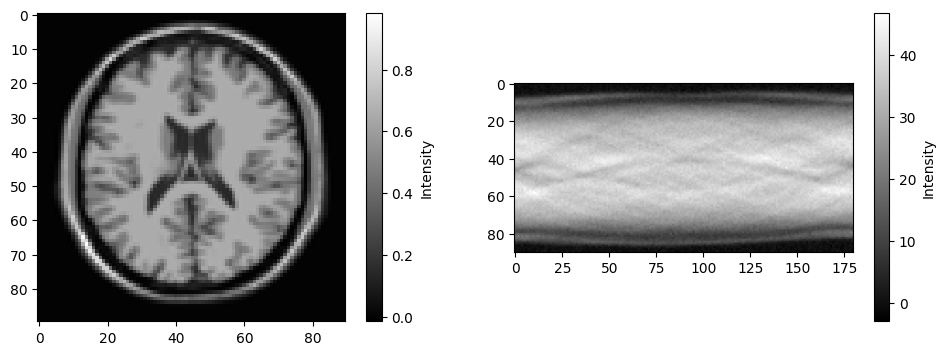

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.colorbar(axs[0].imshow(x_bar_sinogram, cmap='gray'), ax=axs[0], label='Intensity')
fig.colorbar(axs[1].imshow(y_sinogram, cmap='gray'), ax=axs[1], label='Intensity')
plt.show()
plt.close(fig)

## II. Optimization problem

In [87]:
def phi(x: np.ndarray) -> float:
    def phi_scalar(x: float) -> float:
        return np.sqrt(1 + x**2/delta**2)
    phi_vect = np.vectorize(phi_scalar)
    return phi_vect(x)

def phi_prime(x: np.ndarray) -> np.ndarray:
    def phi_prime_scalar(x: float) -> float:
        return x/((delta**2)*phi(x))
    phi_prime_vect = np.vectorize(phi_prime_scalar)
    return phi_prime_vect(x)

def phi_second(x: np.ndarray) -> np.ndarray:
    def phi_second_scalar(x: float) -> float:
        return (phi(x) - x * phi_prime(x))/(delta**2 * phi(x)**2)
    phi_second_vect = np.vectorize(phi_second_scalar)
    return phi_second_vect(x)

def r(x: np.ndarray, G:np.ndarray) -> float:
    return np.sum(phi(G @ x))

def grad_r(x: np.ndarray, G:np.ndarray) -> np.ndarray:
    return G.T @ phi_prime(G @ x)

# def hessian_r(x: np.ndarray, G:np.ndarray) -> np.ndarray:
#     return G.T @ np.diag(phi_second(G @ x).flatten()) @ G        

def f(x: np.ndarray, H: np.ndarray, G:np.ndarray, y:np.array) -> float:
    return 0.5 * np.linalg.norm(H @ x - y)**2 + lambda_ * r(x, G)

def grad_f(x: np.ndarray, H: np.ndarray, G: np.ndarray, y:np.array) -> np.ndarray:
    return H.T @ (H @ x - y) + lambda_ * grad_r(x, G)

def grad_fj(x: np.ndarray, H: np.ndarray, G: np.ndarray, y:np.array, indices: np.ndarray) -> np.ndarray:
    return (H.T)[indices,:] @ (H @ x - y) + lambda_ * grad_r(x, G)[indices]

# def hessian_f(x: np.ndarray, H: np.ndarray,G:np.ndarray, y:np.array) -> np.ndarray:
#     return H.T @ H + lambda_ * hessian_r(x, G)

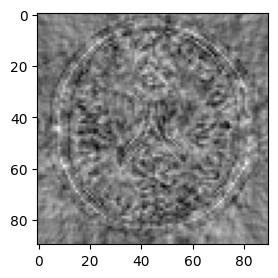

In [88]:
grad_test = grad_f(x_bar, H, G, y)
plt.figure(figsize=(3,3))
plt.imshow(grad_test.reshape((90, 90), order='F'), cmap='gray')
plt.show()
plt.close()

### Q3

## Optimization algorithms

In [89]:
x0 = np.zeros(N)
x0.flags.writeable = False

L = scipy.sparse.linalg.svds(H, k=1, return_singular_vectors=False)[0]**2 + (lambda_/delta**2) * scipy.sparse.linalg.svds(G, k=1, return_singular_vectors=False)[0]**2


### I. Gradient Descent

In [90]:
def grad_desc(x0: np.ndarray, eta: float, lambda_: float, delta: float, max_iter: int):
    x = x0.copy()
    loss_history = []
    grad_norm_history = []
    x_history = []
    for i in tqdm(range(max_iter)):
        x = x - eta*grad_f(x, H, G, y) 
        loss_history.append(f(x, H, G, y))
        x_history.append(x)
        if i%100 == 0:
            grad_norm_history.append(np.linalg.norm(grad_f(x, H, G, y)))
            print(f'Iter {i}, Loss {loss_history[-1]}, Grad {grad_norm_history[-1]}')
            if grad_norm_history[-1] < np.sqrt(N)*1e-2:
                print("Gradient descent converged after {} iterations".format(i))
                break
    return x, loss_history, x_history, grad_norm_history

  0%|          | 3/1000 [00:00<02:06,  7.87it/s]

Iter 0, Loss 416076.33821627626, Grad 75096.847974026


 10%|█         | 102/1000 [00:10<01:40,  8.93it/s]

Iter 100, Loss 13518.726429678367, Grad 507.3785125005627


 20%|██        | 202/1000 [00:20<01:28,  8.98it/s]

Iter 200, Loss 13042.234591799166, Grad 149.8565640612418


 30%|███       | 302/1000 [00:30<01:20,  8.67it/s]

Iter 300, Loss 12978.390198850342, Grad 74.41746289841765


 40%|████      | 402/1000 [00:41<01:13,  8.18it/s]

Iter 400, Loss 12959.436191540133, Grad 45.010089179984504


 50%|█████     | 502/1000 [00:51<01:00,  8.29it/s]

Iter 500, Loss 12951.872004125784, Grad 29.857343225100408


 60%|██████    | 602/1000 [01:01<00:49,  8.02it/s]

Iter 600, Loss 12948.355226328546, Grad 21.003654600882797


 70%|███████   | 702/1000 [01:12<00:36,  8.20it/s]

Iter 700, Loss 12946.54819799284, Grad 15.380949022387895


 80%|████████  | 802/1000 [01:22<00:24,  8.24it/s]

Iter 800, Loss 12945.551641180768, Grad 11.597900742065617


 90%|█████████ | 902/1000 [01:32<00:11,  8.26it/s]

Iter 900, Loss 12944.9741611946, Grad 8.917500440179113


100%|██████████| 1000/1000 [01:42<00:00,  9.72it/s]


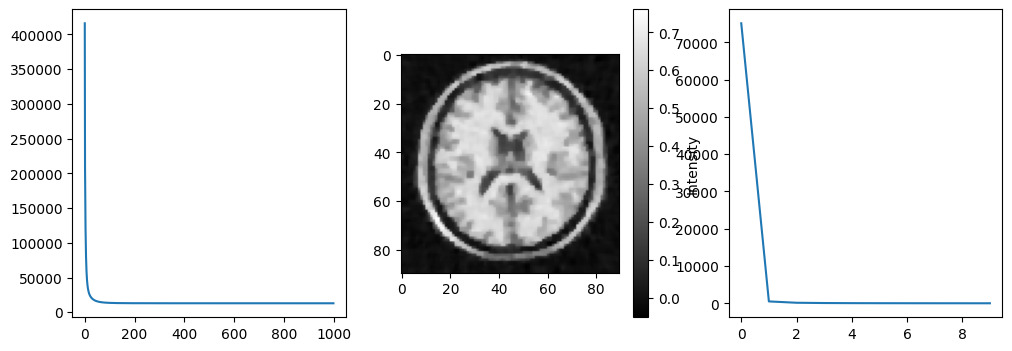

<Figure size 640x480 with 0 Axes>

In [91]:
eta = 1/L
max_iter = 1000
x_gd, loss_history_gd, x_history_gd, grad_norm_history_gd = grad_desc(x0, eta, lambda_, delta, max_iter)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(loss_history_gd)
fig.colorbar(axs[1].imshow(x_gd.reshape((90,90), order='F'), cmap='gray'), ax=axs[1], label='Intensity')
axs[2].plot(grad_norm_history_gd)
plt.show()
plt.savefig('results/grad_desc.png')
plt.close(fig)

### II. MM quadratic algorithm

In [92]:
from scipy.sparse import diags
from scipy.sparse.linalg import LinearOperator, cg, eigsh, bicg


def A(x: np.ndarray) -> np.ndarray:
    d = np.full(N, L + 1)      # check that 1 is a good margin
    curvature = diags(d).tocsc()

    def matvec(v):
        return curvature @ v
    
    def rmatvec(v):
        return curvature.T @ v
    
    A = LinearOperator((N, N), matvec=matvec, rmatvec=rmatvec)
    return A


def mm_algorithm(x0: np.ndarray, theta: float, max_iter: int): #theta cst over the iterations for now
    x = x0.copy()
    loss_history = []
    x_history = []
    grad_norm_history = []
    for i in tqdm(range(max_iter)):
        grad_mm = grad_f(x, H, G, y)
        A_mm = A(x)
        v, info = bicg(A_mm, grad_mm)
        if info != 0:
            raise ValueError ("CG did not converge")
        
        x = x - theta*v 
        x_history.append(x)
        loss_history.append(f(x, H, G, y))
        if i%50 == 0:
            grad_norm_history.append(np.linalg.norm(grad_f(x, H, G, y)))
            print(f'Iter {i}, Loss {loss_history[-1]}, Grad {grad_norm_history[-1]}')
            if grad_norm_history[-1] < np.sqrt(N)*1e-2:
                print("MM algorithm converged after {} iterations".format(i))
                break
    return x, loss_history, x_history, grad_norm_history

  0%|          | 3/1000 [00:00<02:06,  7.86it/s]

Iter 0, Loss 3466455.355457028, Grad 319933.7191062314


  5%|▌         | 52/1000 [00:05<01:46,  8.87it/s]

Iter 50, Loss 13492.449918497301, Grad 490.3358860627358


 10%|█         | 102/1000 [00:10<01:43,  8.71it/s]

Iter 100, Loss 13039.952809870429, Grad 146.9969381966709


 15%|█▌        | 152/1000 [00:15<01:41,  8.32it/s]

Iter 150, Loss 12977.861884137463, Grad 73.5520021991988


 20%|██        | 202/1000 [00:20<01:36,  8.28it/s]

Iter 200, Loss 12959.245938191918, Grad 44.61843612814464


 25%|██▌       | 252/1000 [00:26<01:32,  8.09it/s]

Iter 250, Loss 12951.787794720876, Grad 29.6402108937076


 30%|███       | 302/1000 [00:31<01:25,  8.15it/s]

Iter 300, Loss 12948.313110776748, Grad 20.8693929956647


 35%|███▌      | 352/1000 [00:36<01:18,  8.24it/s]

Iter 350, Loss 12946.525360839556, Grad 15.292300678239872


 40%|████      | 402/1000 [00:41<01:12,  8.27it/s]

Iter 400, Loss 12945.538489805751, Grad 11.536206198715782


 45%|████▌     | 452/1000 [00:47<01:08,  8.05it/s]

Iter 450, Loss 12944.96626042285, Grad 8.872514647584495


 50%|█████     | 502/1000 [00:52<01:01,  8.11it/s]

Iter 500, Loss 12944.623414343048, Grad 6.915778124634055


 55%|█████▌    | 552/1000 [00:57<00:54,  8.19it/s]

Iter 550, Loss 12944.413099838053, Grad 5.4455368999195


 60%|██████    | 602/1000 [01:02<00:48,  8.21it/s]

Iter 600, Loss 12944.281691270266, Grad 4.323171151310586


 65%|██████▌   | 652/1000 [01:08<00:42,  8.19it/s]

Iter 650, Loss 12944.19832058413, Grad 3.4564617293202486


 70%|███████   | 702/1000 [01:13<00:36,  8.22it/s]

Iter 700, Loss 12944.144709328082, Grad 2.781237147543409


 75%|███████▌  | 752/1000 [01:18<00:30,  8.22it/s]

Iter 750, Loss 12944.109806353368, Grad 2.2512103490804316


 80%|████████  | 802/1000 [01:24<00:24,  8.22it/s]

Iter 800, Loss 12944.086821226058, Grad 1.8322370798138679


 85%|████████▌ | 852/1000 [01:29<00:18,  8.19it/s]

Iter 850, Loss 12944.071522998292, Grad 1.498824169705151


 90%|█████████ | 902/1000 [01:34<00:11,  8.25it/s]

Iter 900, Loss 12944.061241046145, Grad 1.2317983570563535


 95%|█████████▌| 952/1000 [01:39<00:06,  7.99it/s]

Iter 950, Loss 12944.054268554817, Grad 1.016651847833737


100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s]


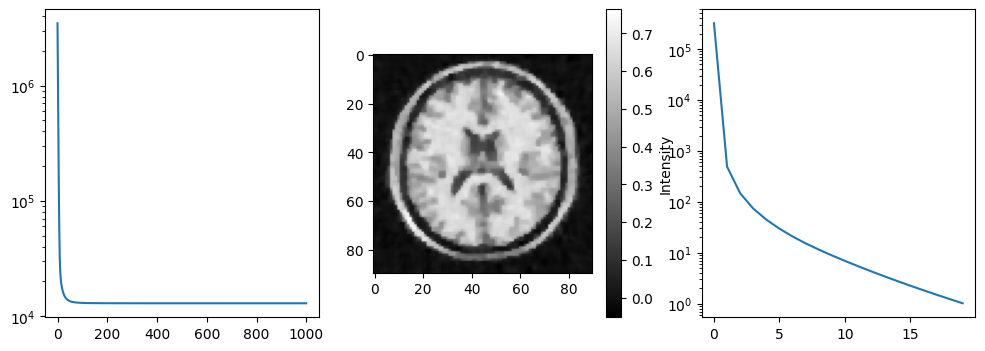

In [93]:
theta = 2
max_iter = 1000
x_mm, loss_history_mm, x_history_mm, grad_norm_history_mm = mm_algorithm(x0, theta, max_iter)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(loss_history_mm)
axs[0].set_yscale('log')
fig.colorbar(axs[1].imshow(x_mm.reshape((90,90), order='F'), cmap='gray'), ax=axs[1], label='Intensity')
axs[2].plot(grad_norm_history_mm)
axs[2].set_yscale('log')
plt.show()
plt.close(fig)

### III. 3MG algo

In [94]:
def mg_algo(x0: np.ndarray, max_iter: int) -> np.ndarray:
    x = x0.copy()
    loss_history = []
    x_history = []
    grad_norm_history = []
    D = np.zeros((N, 2))
    for i in tqdm(range(max_iter)):
        D[:,0] = -grad_f(x, H, G, y)
        A3mg = A(x)
        u = -np.linalg.pinv(D.T @ A3mg @ D) @ (D.T @ grad_f(x, H, G, y))
        x += D @ u
        D[:,1] = D @ u
        loss_history.append(f(x, H, G, y))
        x_history.append(x)
        if i%20 == 0:
            grad_norm_history.append(np.linalg.norm(grad_f(x, H, G, y)))
            print(f'Iter {i}, Loss {loss_history[-1]}, Grad {grad_norm_history[-1]}')
            if grad_norm_history[-1] < np.sqrt(N)*1e-2:
                print("3MG algorithm converged after {} iterations".format(i))
                break
    return x, loss_history, x_history, grad_norm_history

  0%|          | 2/1000 [00:00<03:50,  4.32it/s]

Iter 0, Loss 416169.7801002802, Grad 75115.20725649102


  2%|▏         | 22/1000 [00:04<03:25,  4.75it/s]

Iter 20, Loss 24626.380362725, Grad 3688.3229933467683


  4%|▍         | 42/1000 [00:08<03:21,  4.75it/s]

Iter 40, Loss 17097.520612500062, Grad 1799.8061854526989


  6%|▌         | 62/1000 [00:12<03:17,  4.74it/s]

Iter 60, Loss 14836.476829270341, Grad 1096.0643906343178


  8%|▊         | 82/1000 [00:16<03:14,  4.71it/s]

Iter 80, Loss 13933.991126369578, Grad 724.4277155159238


 10%|█         | 102/1000 [00:20<03:12,  4.67it/s]

Iter 100, Loss 13518.807226621968, Grad 507.4259560803391


 12%|█▏        | 122/1000 [00:24<03:08,  4.65it/s]

Iter 120, Loss 13306.504332659373, Grad 372.2084261264968


 14%|█▍        | 142/1000 [00:28<03:06,  4.59it/s]

Iter 140, Loss 13188.216830312258, Grad 283.7279364978189


 16%|█▌        | 162/1000 [00:32<02:58,  4.70it/s]

Iter 160, Loss 13117.416688732454, Grad 223.37179948109872


 18%|█▊        | 182/1000 [00:36<02:56,  4.64it/s]

Iter 180, Loss 13072.401583692721, Grad 180.77886428064625


 20%|██        | 202/1000 [00:40<02:51,  4.66it/s]

Iter 200, Loss 13042.248502714981, Grad 149.87134942496644


 22%|██▏       | 222/1000 [00:44<02:46,  4.66it/s]

Iter 220, Loss 13021.114980304512, Grad 126.8521500592227


 24%|██▍       | 242/1000 [00:48<02:41,  4.70it/s]

Iter 240, Loss 13005.726435183642, Grad 109.19704886522707


 26%|██▌       | 262/1000 [00:52<02:37,  4.68it/s]

Iter 260, Loss 12994.18019132092, Grad 95.20801747314462


 28%|██▊       | 282/1000 [00:56<02:33,  4.68it/s]

Iter 280, Loss 12985.319255631755, Grad 83.8278657938703


 30%|███       | 302/1000 [01:00<02:29,  4.66it/s]

Iter 300, Loss 12978.395318724275, Grad 74.42461339013138


 32%|███▏      | 322/1000 [01:04<02:29,  4.55it/s]

Iter 320, Loss 12972.898581191115, Grad 66.57062403888995


 34%|███▍      | 342/1000 [01:08<02:20,  4.69it/s]

Iter 340, Loss 12968.473154526833, Grad 59.93236010963354


 36%|███▌      | 362/1000 [01:12<02:16,  4.68it/s]

Iter 360, Loss 12964.8674198745, Grad 54.248023449071496


 38%|███▊      | 382/1000 [01:16<02:12,  4.68it/s]

Iter 380, Loss 12961.90038818865, Grad 49.32225528425719


 40%|████      | 402/1000 [01:20<02:08,  4.65it/s]

Iter 400, Loss 12959.438683451077, Grad 45.01457129647392


 42%|████▏     | 422/1000 [01:24<02:04,  4.65it/s]

Iter 420, Loss 12957.381498769346, Grad 41.22293698554436


 44%|████▍     | 442/1000 [01:28<01:58,  4.70it/s]

Iter 440, Loss 12955.651074095804, Grad 37.869624601127555


 46%|████▌     | 462/1000 [01:32<01:55,  4.66it/s]

Iter 460, Loss 12954.18658913028, Grad 34.89195724658974


 48%|████▊     | 482/1000 [01:36<01:50,  4.68it/s]

Iter 480, Loss 12952.940054845683, Grad 32.23723340504457


 50%|█████     | 502/1000 [01:40<01:46,  4.67it/s]

Iter 500, Loss 12951.873373148395, Grad 29.860465650105635


 52%|█████▏    | 522/1000 [01:44<01:44,  4.58it/s]

Iter 520, Loss 12950.956120468796, Grad 27.72343417084858


 54%|█████▍    | 541/1000 [01:48<01:41,  4.51it/s]

Iter 540, Loss 12950.163837804661, Grad 25.794019263103024


 56%|█████▌    | 562/1000 [01:52<01:33,  4.68it/s]

Iter 560, Loss 12949.476710060477, Grad 24.045473665634255


 58%|█████▊    | 582/1000 [01:56<01:29,  4.68it/s]

Iter 580, Loss 12948.878552494003, Grad 22.455612146266397


 60%|██████    | 602/1000 [02:00<01:25,  4.68it/s]

Iter 600, Loss 12948.356038680486, Grad 21.005958403834963


 62%|██████▏   | 622/1000 [02:04<01:21,  4.66it/s]

Iter 620, Loss 12947.898115782786, Grad 19.680928042876065


 64%|██████▍   | 641/1000 [02:08<01:19,  4.50it/s]

Iter 640, Loss 12947.495561278547, Grad 18.46713772891581


 66%|██████▌   | 662/1000 [02:12<01:12,  4.69it/s]

Iter 660, Loss 12947.140643320026, Grad 17.352889330382098


 68%|██████▊   | 682/1000 [02:16<01:08,  4.67it/s]

Iter 680, Loss 12946.8268556094, Grad 16.32782408090666


 70%|███████   | 701/1000 [02:20<01:06,  4.48it/s]

Iter 700, Loss 12946.548705951065, Grad 15.382710317915405


 72%|███████▏  | 721/1000 [02:24<01:02,  4.48it/s]

Iter 720, Loss 12946.301544351809, Grad 14.509319018947389


 74%|███████▍  | 741/1000 [02:28<00:58,  4.46it/s]

Iter 740, Loss 12946.081421400471, Grad 13.700344485602741


 76%|███████▌  | 762/1000 [02:32<00:50,  4.68it/s]

Iter 760, Loss 12945.884970872496, Grad 12.949338346887858


 78%|███████▊  | 782/1000 [02:36<00:46,  4.64it/s]

Iter 780, Loss 12945.70931240957, Grad 12.250639470656186


 80%|████████  | 802/1000 [02:40<00:42,  4.66it/s]

Iter 800, Loss 12945.551971124418, Grad 11.59929508712614


 82%|████████▏ | 822/1000 [02:44<00:38,  4.66it/s]

Iter 820, Loss 12945.410811478218, Grad 10.990976141178992


 84%|████████▍ | 842/1000 [02:48<00:34,  4.63it/s]

Iter 840, Loss 12945.283983074218, Grad 10.42189261912759


 86%|████████▌ | 862/1000 [02:52<00:29,  4.69it/s]

Iter 860, Loss 12945.169876265947, Grad 9.888714150724038


 88%|████████▊ | 882/1000 [02:56<00:25,  4.67it/s]

Iter 880, Loss 12945.067085747363, Grad 9.388499398970763


 90%|█████████ | 902/1000 [03:00<00:21,  4.66it/s]

Iter 900, Loss 12944.974380573916, Grad 8.918635783387744


 92%|█████████▏| 922/1000 [03:05<00:16,  4.61it/s]

Iter 920, Loss 12944.890679339314, Grad 8.4767895012039


 94%|█████████▍| 942/1000 [03:09<00:12,  4.60it/s]

Iter 940, Loss 12944.815029485071, Grad 8.060864805256477


 96%|█████████▌| 962/1000 [03:13<00:08,  4.67it/s]

Iter 960, Loss 12944.746589935716, Grad 7.668971036694447


 98%|█████████▊| 982/1000 [03:17<00:03,  4.68it/s]

Iter 980, Loss 12944.684616429413, Grad 7.299395855444317


100%|██████████| 1000/1000 [03:20<00:00,  4.99it/s]


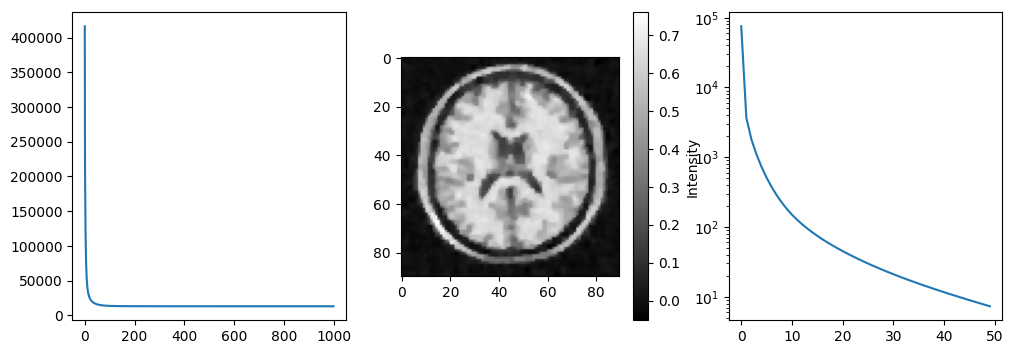

In [95]:
max_iter = 1000
x_3mg, loss_history_3mg, x_history_3mg, grad_norm_history_3mg = mg_algo(x0, max_iter)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(loss_history_3mg)
fig.colorbar(axs[1].imshow(x_3mg.reshape((90,90), order='F'), cmap='gray'), ax=axs[1], label='Intensity')
axs[2].plot(grad_norm_history_3mg)
axs[2].set_yscale('log')
plt.show()
plt.close(fig)

### IV. Block coordinate MM quadratic algorithm

In [96]:
import time

def Aj(x: np.ndarray, Nj:int) -> np.ndarray:
    d = np.full(Nj, L + 1)      # check that 1 is a good margin
    curvature = diags(d).tocsc()

    def matvec(v):
        return curvature @ v
    
    def rmatvec(v):
        return curvature.T @ v
    
    Aj = LinearOperator((Nj, Nj), matvec=matvec, rmatvec=rmatvec)

    return Aj


def block_mm(x0: np.array, theta: float, max_iter: int, J:int) -> np.array:
    x = x0.copy()
    Nj = N//J
    x_history = []
    loss_history = []
    grad_norm_history = []
    for i in tqdm(range(max_iter)):
        j = i%J
        indices = range(Nj*j, Nj*(j+1))
        xj = x[indices]
        Aj_mm = Aj(x, Nj)
        gradj = grad_f(x, H, G, y)[indices]
        v, info = cg(Aj_mm, gradj)
        if info != 0:
            raise ValueError("Conjugate gradient solver did not converge")

        x[indices] = xj - theta*v       
        x_history.append(x)
        loss_history.append(f(x, H, G, y))
        if i%30 == 0:
            grad_norm_history.append(np.linalg.norm(gradj))
            print(f'Iter {i}, Loss {loss_history[-1]}, Grad {grad_norm_history[-1]}')
            if grad_norm_history[-1] < np.sqrt(N)*1e-2:
                break
    return x, loss_history, x_history, grad_norm_history

  1%|          | 3/300 [00:00<00:30,  9.81it/s]

Iter 0, Loss 5064204.483508037, Grad 153035.0794818501


 11%|█         | 32/300 [00:03<00:27,  9.57it/s]

Iter 30, Loss 37969.285930451595, Grad 3110.3267794123444


 21%|██        | 62/300 [00:06<00:24,  9.74it/s]

Iter 60, Loss 23104.923617698336, Grad 1462.2556660803818


 31%|███       | 92/300 [00:09<00:21,  9.72it/s]

Iter 90, Loss 18367.813284559066, Grad 950.7536855581517


 41%|████      | 122/300 [00:12<00:18,  9.68it/s]

Iter 120, Loss 16157.946846066097, Grad 673.238767877519


 51%|█████     | 152/300 [00:15<00:15,  9.74it/s]

Iter 150, Loss 14979.208865667055, Grad 499.96866893475135


 61%|██████    | 182/300 [00:18<00:12,  9.75it/s]

Iter 180, Loss 14299.382158560957, Grad 383.974591070512


 71%|███████   | 212/300 [00:21<00:09,  9.68it/s]

Iter 210, Loss 13884.87019687601, Grad 302.5398321788966


 81%|████████  | 242/300 [00:25<00:05,  9.75it/s]

Iter 240, Loss 13620.854432406892, Grad 243.33307456848246


 91%|█████████ | 272/300 [00:28<00:02,  9.44it/s]

Iter 270, Loss 13446.41629069089, Grad 199.16310747541254


100%|██████████| 300/300 [00:31<00:00,  9.64it/s]


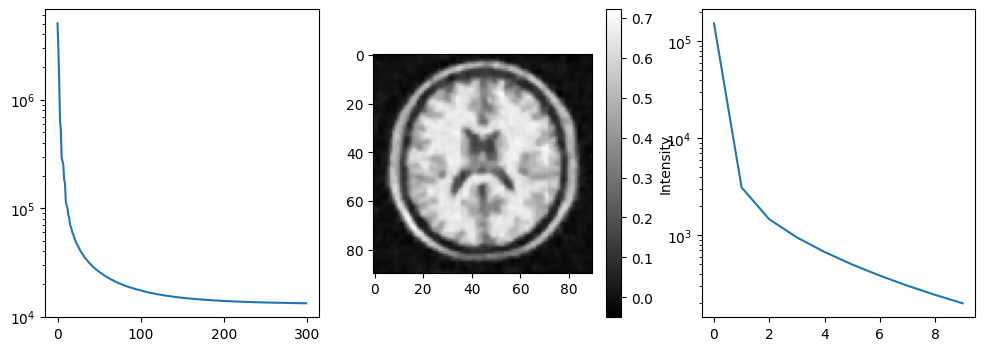

In [97]:
theta = 2
max_iter = 300
J = 5
x_block_mm, loss_history_block_mm, x_history_block_mm, grad_norm_history_block_mm = block_mm(x0, theta, max_iter, J)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(loss_history_block_mm)
axs[0].set_yscale('log')
fig.colorbar(axs[1].imshow(x_block_mm.reshape((90,90), order='F'), cmap='gray'), ax=axs[1], label='Intensity')
axs[2].plot(grad_norm_history_block_mm)
axs[2].set_yscale('log')
plt.show()
plt.close(fig)

### V. Parallel MM quadratic algorithm

In [98]:
def phi_prime_over_id(x: np.ndarray) -> np.ndarray:
    def phi_prime_over_id_scalar(x: float) -> float:
        return x/((delta**2)*phi(x))
    phi_prime_over_id_vect = np.vectorize(phi_prime_over_id_scalar)
    return phi_prime_over_id_vect(x)

row_sums_H = H @ np.ones(N)
row_sums_G = G @ np.ones(N)
cal_H = H.T @ np.diag(row_sums_H)
cal_H = csr_matrix(cal_H) 
cal_G = G.T @ np.diag(row_sums_G)
cal_G = csr_matrix(cal_G) 

def B(x: np.ndarray, indices) -> np.ndarray:
    b = cal_H[indices,:] @ np.ones(M) + lambda_ * cal_G[indices,:] @ phi_prime_over_id(G @ x)
    b = diags(b).tocsc()

    def matvec(v):
        return b @ v
    
    def rmatvec(v):
        return b.T @ v
    
    Nj = len(indices)
    B = LinearOperator((Nj, Nj), matvec=matvec, rmatvec=rmatvec)
    return B

In [65]:
def parallel_mm_algo(x0, theta: float, J:int, max_iter: int):
    x = x0.copy()
    Nj = N//J
    x_history = []
    loss_history = []
    grad_norm_history = []
    for i in tqdm(range(max_iter)):
        j = i%J
        indices = range(Nj*j, Nj*(j+1))
        xj = x[indices]
        B_mm = B(x, indices)
        grad_mm = grad_fj(x, H, G, y, indices)
        v, info = cg(B_mm, grad_mm)
        if info != 0:
            raise ValueError("Conjugate gradient solver did not converge")
        x[indices] -= theta*v
        x_history.append(x)
        loss_history.append(f(x, H, G, y))
        if i%30 == 0:
            grad_norm_history.append(np.linalg.norm(grad_f(x, H, G, y)))
            print(f'Iter: {i}, Loss: {loss_history[-1]}, Grad Norm: {grad_norm_history[-1]}')
    return x, loss_history, x_history, grad_norm_history

In [66]:
theta = 1
max_iter = 1000
J = 2
x_parallel_mm, loss_history_parallel_mm, x_history_parallel_mm, grad_norm_history_parallel_mm = parallel_mm_algo(x0, theta, J, max_iter) 

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(loss_history_parallel_mm)
fig.colorbar(axs[1].imshow(x_parallel_mm.reshape((90,90), order='F'), cmap='gray'), ax=axs[1], label='Intensity')
axs[2].plot(grad_norm_history_parallel_mm)
axs[2].set_yscale('log')
axs[2].yaxis.set_label_position("right")
plt.show()
plt.close(fig)

  0%|          | 2/1000 [00:00<03:56,  4.22it/s]

Iter: 0, Loss: 2647159.4784458936, Grad Norm: 247770.03878252773


  3%|▎         | 32/1000 [00:06<03:29,  4.61it/s]

Iter: 30, Loss: 27483.611252675633, Grad Norm: 4398.756201303997


  6%|▌         | 62/1000 [00:12<03:25,  4.57it/s]

Iter: 60, Loss: 18362.09477398368, Grad Norm: 2120.703106497471


  9%|▉         | 92/1000 [00:18<03:17,  4.59it/s]

Iter: 90, Loss: 15557.176580536992, Grad Norm: 1338.6762682571734


 12%|█▏        | 122/1000 [00:24<03:11,  4.59it/s]

Iter: 120, Loss: 14360.723012558972, Grad Norm: 911.0638510026112


 15%|█▌        | 151/1000 [00:30<03:26,  4.11it/s]

Iter: 150, Loss: 13781.643664289797, Grad Norm: 651.1017886990518


 18%|█▊        | 181/1000 [00:37<03:16,  4.18it/s]

Iter: 180, Loss: 13475.578737936346, Grad Norm: 483.17311834390074


 21%|██        | 211/1000 [00:43<03:09,  4.16it/s]

Iter: 210, Loss: 13301.981045570074, Grad Norm: 370.33841662969917


 24%|██▍       | 242/1000 [00:50<02:51,  4.42it/s]

Iter: 240, Loss: 13197.259086174443, Grad Norm: 292.128098068656


 27%|██▋       | 271/1000 [00:56<02:46,  4.38it/s]

Iter: 270, Loss: 13130.576985811433, Grad Norm: 236.23907188570604


 30%|██▉       | 298/1000 [01:02<02:21,  4.98it/s]

### VI. Comparison of the methods

In [42]:
def SNR(x: np.ndarray, x_bar: np.ndarray) -> float:
    return 10*np.log10(np.linalg.norm(x_bar)**2/np.linalg.norm(x - x_bar)**2)

print(f'SNR for gradient descent: {SNR(x_gd, x_bar)}')
print(f'SNR for MM algorithm: {SNR(x_mm, x_bar)}')
print(f'SNR for 3MG algorithm: {SNR(x_3mg, x_bar)}')
print(f'SNR for block MM algorithm: {SNR(x_block_mm, x_bar)}')
print(f'SNR for parallel MM algorithm: {SNR(x_parallel_mm, x_bar)}')

SNR for gradient descent: 10.010826625726928
SNR for MM algorithm: 12.075269568575429
SNR for 3MG algorithm: 10.010669847813851
SNR for block MM algorithm: 19.295520811700083
SNR for parallel MM algorithm: 13.330184246432058


In [69]:
_, loss_history_gd300, _, _ = grad_desc(x0, eta, lambda_, delta, 300)
_, loss_history_mm300, _, _ = mm_algorithm(x0, theta, 300)
_, loss_history_3mg300, _, _ = mg_algo(x0, 300)
_, loss_history_block_mm300, _, _ = block_mm(x0, theta, 300, 3)
_, loss_history_parallel_mm300, _, _ = parallel_mm_algo(x0, theta, 3, 300)

  1%|          | 3/300 [00:00<00:36,  8.16it/s]

Iter 0, Loss 415430.3105881212, Grad 75065.03111189071


 34%|███▍      | 102/300 [00:10<00:23,  8.32it/s]

Iter 100, Loss 13488.01314521076, Grad 500.58602986319346


 67%|██████▋   | 202/300 [00:20<00:11,  8.19it/s]

Iter 200, Loss 13022.382878973272, Grad 150.72185192253997


  1%|          | 2/300 [00:00<00:42,  7.07it/s]

Iter 0, Loss 415523.72313943, Grad 75083.39462250793


 17%|█▋        | 52/300 [00:05<00:30,  8.24it/s]

Iter 50, Loss 15624.430695768671, Grad 1379.375414453251


 34%|███▍      | 102/300 [00:10<00:24,  8.14it/s]

Iter 100, Loss 13488.091799893496, Grad 500.6331175259671


 51%|█████     | 152/300 [00:16<00:18,  7.99it/s]

Iter 150, Loss 13127.905163984291, Grad 248.20951906340755


 67%|██████▋   | 202/300 [00:21<00:12,  8.01it/s]

Iter 200, Loss 13022.396946236957, Grad 150.73625121703483


 84%|████████▍ | 252/300 [00:26<00:06,  7.63it/s]

Iter 250, Loss 12978.852875370241, Grad 103.21635696170326


  1%|          | 2/300 [00:00<01:13,  4.08it/s]

Iter 0, Loss 415523.7231394313, Grad 75083.39462250817


  7%|▋         | 22/300 [00:04<00:59,  4.63it/s]

Iter 20, Loss 24541.537112783946, Grad 3691.7323586027055


 14%|█▍        | 42/300 [00:08<00:54,  4.69it/s]

Iter 40, Loss 17019.2339533994, Grad 1794.047041978657


 21%|██        | 62/300 [00:12<00:54,  4.36it/s]

Iter 60, Loss 14780.171246518441, Grad 1088.1573142436425


 27%|██▋       | 82/300 [00:16<00:46,  4.68it/s]

Iter 80, Loss 13893.386620514166, Grad 716.6435448468199


 34%|███▍      | 102/300 [00:20<00:42,  4.63it/s]

Iter 100, Loss 13488.091799893551, Grad 500.6331175259998


 41%|████      | 122/300 [00:24<00:40,  4.44it/s]

Iter 120, Loss 13281.673486068481, Grad 366.8941461777907


 47%|████▋     | 142/300 [00:28<00:34,  4.63it/s]

Iter 140, Loss 13166.614418506073, Grad 280.1843743604726


 54%|█████▍    | 162/300 [00:32<00:29,  4.66it/s]

Iter 160, Loss 13097.297418730497, Grad 221.67737194730847


 61%|██████    | 182/300 [00:37<00:25,  4.57it/s]

Iter 180, Loss 13052.692109344807, Grad 180.64454794705958


 67%|██████▋   | 202/300 [00:41<00:20,  4.69it/s]

Iter 200, Loss 13022.396946236893, Grad 150.7362512169731


 74%|███████▎  | 221/300 [00:44<00:17,  4.50it/s]

Iter 220, Loss 13000.924894594318, Grad 128.13658051309807


 80%|████████  | 241/300 [00:48<00:13,  4.51it/s]

Iter 240, Loss 12985.184337842427, Grad 110.57592938410413


 87%|████████▋ | 262/300 [00:53<00:08,  4.69it/s]

Iter 260, Loss 12973.321359025886, Grad 96.62137678918535


 94%|█████████▍| 282/300 [00:57<00:03,  4.69it/s]

Iter 280, Loss 12964.171690544463, Grad 85.3224803184121


  1%|          | 2/300 [00:00<00:30,  9.67it/s]

Iter 0, Loss 4521786.560321731, Grad 232188.20907022938


 11%|█         | 32/300 [00:03<00:29,  9.24it/s]

Iter 30, Loss 46214.67061615515, Grad 5446.496517182443


 21%|██        | 62/300 [00:06<00:24,  9.70it/s]

Iter 60, Loss 25422.345332981964, Grad 2233.968864028669


 31%|███       | 92/300 [00:09<00:21,  9.56it/s]

Iter 90, Loss 19836.68745793449, Grad 1476.2891894298912


 41%|████      | 122/300 [00:13<00:21,  8.37it/s]

Iter 120, Loss 17210.383091573203, Grad 1094.728923805791


 51%|█████     | 152/300 [00:16<00:15,  9.70it/s]

Iter 150, Loss 15736.847675321545, Grad 846.1105399120358


 61%|██████    | 182/300 [00:19<00:12,  9.62it/s]

Iter 180, Loss 14848.3061203976, Grad 671.2990242568981


 71%|███████   | 212/300 [00:22<00:09,  9.75it/s]

Iter 210, Loss 14287.52577825628, Grad 543.3991197645502


 81%|████████  | 242/300 [00:25<00:06,  9.65it/s]

Iter 240, Loss 13920.424542571986, Grad 447.10950905884135


 91%|█████████ | 272/300 [00:28<00:03,  9.28it/s]

Iter 270, Loss 13672.410013342194, Grad 372.9870872829383


  1%|          | 2/300 [00:00<01:09,  4.26it/s]

Iter: 0, Loss: 4255284.134841067, Grad Norm: 331676.95595557836


 11%|█         | 32/300 [00:06<00:57,  4.64it/s]

Iter: 30, Loss: 40955.267289072304, Grad Norm: 7836.210668120134


 20%|██        | 61/300 [00:12<00:54,  4.38it/s]

Iter: 60, Loss: 23171.70031664246, Grad Norm: 3359.3964813738767


 30%|███       | 91/300 [00:18<00:48,  4.35it/s]

Iter: 90, Loss: 18434.77044716898, Grad Norm: 2165.161301641883


 41%|████      | 122/300 [00:24<00:38,  4.57it/s]

Iter: 120, Loss: 16228.45545109616, Grad Norm: 1563.501858720442


 51%|█████     | 152/300 [00:30<00:31,  4.64it/s]

Iter: 150, Loss: 15029.850741749598, Grad Norm: 1179.5653671083883


 60%|██████    | 181/300 [00:37<00:28,  4.17it/s]

Iter: 180, Loss: 14330.654060300507, Grad Norm: 914.3324432912807


 70%|███████   | 211/300 [00:43<00:20,  4.42it/s]

Iter: 210, Loss: 13902.238315996285, Grad Norm: 724.1329295856568


 81%|████████  | 242/300 [00:49<00:12,  4.62it/s]

Iter: 240, Loss: 13628.828104616907, Grad Norm: 584.2610301608688


 91%|█████████ | 272/300 [00:55<00:06,  4.59it/s]

Iter: 270, Loss: 13448.018163418888, Grad Norm: 479.32399744603515


100%|██████████| 300/300 [01:01<00:00,  4.91it/s]


In [70]:
print(f'Loss for gradient descent after 300 iterations: {loss_history_gd300[-1]}')
print(f'Loss for MM algorithm after 300 iterations: {loss_history_mm300[-1]}')
print(f'Loss for 3MG algorithm after 300 iterations: {loss_history_3mg300[-1]}')
print(f'Loss for block MM algorithm after 300 iterations: {loss_history_block_mm300[-1]}')
print(f'Loss for parallel MM algorithm after 300 iterations: {loss_history_parallel_mm300[-1]}')

Loss for gradient descent after 300 iterations: 12957.29236130352
Loss for MM algorithm after 300 iterations: 12957.297742681958
Loss for 3MG algorithm after 300 iterations: 12957.297742681942
Loss for block MM algorithm after 300 iterations: 13505.518347944013
Loss for parallel MM algorithm after 300 iterations: 13328.339569766122


In [83]:
deltas = [0.01, 0.02, 0.03, 0.04, 0.05]
lambdas = [0.1, 0.2, 0.3, 0.4, 0.5]

for delta, lambda_ in tqdm(zip(deltas, lambdas), total=len(deltas)*len(lambdas)):
    delta_best, lambda_best, snr_best = delta, lambda_, -1
    x_mm, _, _, _ = mm_algorithm(x0, 2, 200)
    snr = SNR(x_mm, x_bar)
    if snr > snr_best:
        delta_best, lambda_best, snr_best = delta, lambda_, snr
    
print(f'Best delta: {delta_best}, Best lambda: {lambda_best}, Best SNR: {snr_best}')

  0%|          | 0/25 [00:00<?, ?it/s]


Iter 0, Loss 3465437.5524877403, Grad 319909.45826778375


  2%|▏         | 3/200 [00:00<00:24,  8.10it/s]

Iter 50, Loss 15187.986556748972, Grad 462.03248540340263


Iter 100, Loss 14785.233267702264, Grad 142.78085136627277


Iter 150, Loss 14725.827632593959, Grad 71.96799317155627


  4%|▍         | 1/25 [00:21<08:32, 21.37s/it]

Iter 0, Loss 3466845.4577135416, Grad 319907.46153609385


Iter 50, Loss 16293.384829964487, Grad 453.05926149811404


Iter 100, Loss 15912.929488696573, Grad 134.31123591814261


Iter 150, Loss 15861.890277487015, Grad 65.47330735658903


  8%|▊         | 2/25 [00:42<08:05, 21.11s/it]

Iter 0, Loss 3468367.6391528393, Grad 319906.6627212693


Iter 50, Loss 17487.58054385976, Grad 446.09083793106015


Iter 100, Loss 17124.967352012853, Grad 127.87118075618103


Iter 150, Loss 17079.846879654553, Grad 60.4183810563208


 12%|█▏        | 3/25 [01:03<07:43, 21.08s/it]

Iter 0, Loss 3469932.6864997176, Grad 319906.2690753594


Iter 50, Loss 18743.036721229608, Grad 440.7594527108478


Iter 100, Loss 18394.59723824925, Grad 122.66235667972406


Iter 150, Loss 18353.96868844117, Grad 56.3768798456752


 16%|█▌        | 4/25 [01:24<07:21, 21.03s/it]

Iter 0, Loss 3471517.879899686, Grad 319906.04134801193


Iter 50, Loss 20044.890237813015, Grad 436.92344566759806


Iter 100, Loss 19707.42601319971, Grad 118.37301519550182


Iter 150, Loss 19670.311131779486, Grad 53.0744085295198


 20%|██        | 5/25 [01:45<07:00, 21.04s/it]

Best delta: 0.05, Best lambda: 0.5, Best SNR: 19.129129437199335
